# Boundary conditions (and subdomains) in Devito

In the final notebook of this lecture we will cover how users can introduce sophisticated boundary conditions into their models. A powerful abstraction available in Devito for implementing boundary conditions is the `SubDomain` object. Below, we will implement a PML boundary condition for the 2nd order wave-equation, but first we will familiarize ourselves with the concept of `SubDomain`s. 

## Introduction to `SubDomain`'s

Consider the construction of the following `Grid`:

In [1]:
from devito import Grid
shape = (10, 10, 10)
grid = Grid(shape=shape, extent=shape)

Looking at the `subdomains` property we see:

In [2]:
grid.subdomains

{'domain': SubDomain domain[(x, y, z)],
 'interior': SubDomain interior[(i0x, i0y, i0z)]}

With the creation of `Grid` two subdomains have been generated by default, 'domain' and 'interior'. We will shortly explore how such subdomains are defined, but before continuing let us explore some of their properties a little further.

First, looking at the following:

In [3]:
grid.subdomains['domain']

SubDomain domain[(x, y, z)]

In [4]:
grid.subdomains['domain'].shape

(10, 10, 10)

we see that 'domain' is in fact the entire computational domain. We can check that it has the same dimensions as grid:

In [5]:
grid.subdomains['domain'].dimensions == grid.dimensions

True

However, when we look at the 'interior' subdomain we see:

In [6]:
grid.subdomains['interior']

SubDomain interior[(i0x, i0y, i0z)]

In [7]:
grid.subdomains['interior'].shape

(8, 8, 8)

In [8]:
grid.subdomains['interior'].dimensions == grid.dimensions

False

This subdomain is in fact defined to be the computational grid excluding the 'outermost' grid point in each dimension, hence the shape `(8, 8, 8)`.

The above two subdomains are initialised upon creation of a grid for various internal reasons and users, generally, need not concern themselves with their existence. However, users will often wish to specify their own subdomains to, e.g., specify different physical equations on different parts of a grid. Before returning to an example of the latter, and to familiarise ourselves with the basics, let us dive into an example of how a user could 'explicitly' create subdomains such as 'domain' and 'interior' themselves.

## The `SubDomain` class

To make use of subdomains we first import the `SubDomain` class:

In [9]:
from devito import SubDomain

Here is an example of how to define a subdomain that spans an entire 3D computational grid (this is similar to how 'domain' is defined internally):

In [10]:
class FullDomain(SubDomain):
    name = 'mydomain'
    def define(self, dimensions):
        x, y, z = dimensions
        return {x: x, y: y, z: z}

In the above snippet, we have defined a class `FullDomain` based on `SubDomain` with the method `define` overridden. This method takes as input a set of Dimensions and produces a mapper from which we can create a subdomain. It is through utilizing this mapper that various types of subdomains can be created. The mapper `{x: x, y: y, z: z}` is simply saying that we wish for the three dimensions of our subdomain be exactly the input dimensions `x, y, z`. Note that for a 2D domain we would need to remove one of the dimensions, i.e. `{x: x, y: y}`, or more generally for an N-dimensional domain one could write `{d: d for d in dimensions}`.

Now, lets us compose a subdomain from our class `FullDomain`:

In [11]:
full_domain = FullDomain()

It is important to note that whilst the `full_domain` object has now been initialised, it has not yet been finalised, i.e. it is not currently associated with any grid. To attach this subdomain to a grid we must pass it to the grid during its creation (the subdomain will then be finalised during creation of the grid):

In [12]:
my_grid = Grid(shape = (10, 10, 10), subdomains = (full_domain, ))

If we look at the subdomains of `my_grid` we see that our new subdomain 'mydomain' is now present:

In [13]:
my_grid.subdomains

{'domain': SubDomain domain[(x, y, z)],
 'interior': SubDomain interior[(i0x, i0y, i0z)],
 'mydomain': SubDomain mydomain[(x, y, z)]}

As expected (and intended), the dimensions of our newly defined subdomain match those of 'domain'.

Now, let us create a subdomain consisting of all but the outer grid point in each dimension (similar to 'interior'):

In [14]:
class InnerDomain(SubDomain):
    name = 'inner'
    def define(self, dimensions):
        d = dimensions
        return {d: ('middle', 1, 1) for d in dimensions}

First, note that in the above we have used the shortand `d = dimensions` so that `d` will be a tuple of N-dimensions and then `{d: ... for d in dimensions}` such that our mapper will be valid for N-dimensional grids. Next we note the inclusion of `('middle', 1, 1)`. For mappers of the form `('middle', N, M)`, the `SubDomain` spans a contiguous region of `dimension_size - (N + M)` points starting at (in terms of python indexing) `N` and finishing at ``dimension_size - M - 1``.

The two other options available are `'left'` and `'right'`. For a statement of the form `d: ('left', N)` the `SubDomain` spans a contiguous region of `N` points starting at `d`\'s left extreme. A statement of the form `('right', N)` is analogous to the previous case but starting at the dimensions right extreme instead.

Now, to create a grid containing both of the subdomains defined above, 'mydomain' and 'inner', we simply pass these during the creation of a grid:

In [15]:
inner_domain = InnerDomain()
my_grid = Grid(shape = (10, 10, 10), subdomains = (full_domain, inner_domain))

If our subdomain `'inner'` is defined correctly we would expect it have a shape of `(8, 8, 8)`.

In [16]:
my_grid.subdomains['inner'].shape

(8, 8, 8)

This is indeed the case.

Now, let us look at some simple examples of how to define subdomains using 'middle', 'left' and 'right' and then utilize these in an operator.

The first subdomain we define will consist of the computational grid excluding, in the `x` dimension 3 nodes on the right and 4 on the left and in the `y` dimension, 4 nodes on the left and 3 on the right:

In [17]:
class Middle(SubDomain):
    name = 'middle'
    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 3, 4), y: ('middle', 4, 3)}
mid = Middle()

Now, let us form an equation and evaluate it only on the subdomain 'middle'. To do this we first import some required objects from Devito:

In [18]:
from devito import Function, Eq, Operator

We then create our grid containing the subdomain 'middle' and when forming our equation pass this subdomain to the equation, thus telling Devito to only evaluate that particular equation within the subdomain 'middle':

In [19]:
#NBVAL_IGNORE_OUTPUT
grid = Grid(shape = (10, 10), subdomains = (mid, ))
f = Function(name = 'f', grid = grid)

eq = Eq(f, f+1, subdomain = grid.subdomains['middle'])

op = Operator(eq)()

Operator `Kernel` ran in 0.01 s


The result we expect is that our function `f`'s data should have a values of `1` within the subdomain and `0` elsewhere. Viewing `f`'s data we see this is indeed the case:

In [20]:
f.data

Data([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
      [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
      [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

We now create some additional subdomains utilising `'left'` and `'right'`. The first domain named 'left' will consist of two nodes on the left hand side in the `x` dimension and the entire of the `y` dimension:

In [21]:
class Left(SubDomain):
    name = 'left'
    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', 2), y: y}
ld = Left()

Next, our subdomain named 'right' will consist of the entire `x` dimension and the two 'right-most' nodes in the `y` dimension:

In [22]:
class Right(SubDomain):
    name = 'right'
    def define(self, dimensions):
        x, y = dimensions
        return {x: x, y: ('right', 2)}
rd = Right()

Note that owing to the chosen definitions of 'left' and 'right' there will be four grid points on which these two subdomains overlap.

Then, let us create a grid consisting of the subdomains 'middle', 'left' and 'right' and specify an equation on each of the three subdomains:

In [23]:
grid = Grid(shape = (10, 10), subdomains = (mid, ld, rd))
f = Function(name = 'f', grid = grid)

eq1 = Eq(f, f+1, subdomain = grid.subdomains['middle'])
eq2 = Eq(f, f+2, subdomain = grid.subdomains['left'])
eq3 = Eq(f, f+3, subdomain = grid.subdomains['right'])

We then create and execute an operator that evaluates the above equations:

In [24]:
#NBVAL_IGNORE_OUTPUT
op2 = Operator([eq1, eq2, eq3])()

Operator `Kernel` ran in 0.01 s


Viewing the data of `f` after performing the operation we see that:

In [25]:
f.data

Data([[2., 2., 2., 2., 2., 2., 2., 2., 5., 5.],
      [2., 2., 2., 2., 2., 2., 2., 2., 5., 5.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.],
      [0., 0., 0., 0., 1., 1., 1., 0., 3., 3.],
      [0., 0., 0., 0., 1., 1., 1., 0., 3., 3.],
      [0., 0., 0., 0., 1., 1., 1., 0., 3., 3.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.],
      [0., 0., 0., 0., 0., 0., 0., 0., 3., 3.]], dtype=float32)

## Configuring PMLs

We now demonstrate how users can implement various boundary conditions in Devito, building on concepts introduced above. We will cover the implementation of both free surface boundary conditions and perfectly-matched layers (PMLs) in the context of the 2nd-order acoustic wave equation. This tutorial is based on the PML implementation outlined in Liu et al's proceeding (https://doi.org/10.1190/1.3627807).

We will set up our domain with PMLs along the left, right, and bottom edges, and free surface boundaries at the top as shown below.

<img src="figures/boundary_conditions.png" style="width: 220px;"/>

Note that whilst in practice we would want the PML tapers to overlap in the corners, this requires additional subdomains. As such, they are omitted for simplicity.

Note that for the purpose of this workshop we will focus on the general idea of the implementation and not the mathematics of the PMLs themselves.

As always, we will begin by specifying some parameters for our `Grid`:

In [26]:
shape = (101, 101)
extent = (2000., 2000.)
nbpml = 10  # Number of PMLs on each side

We will need to use subdomains to accommodate the modified equations in the PML regions. As discussed above, since `Grid` objects cannot have subdomains added retroactively, we must define our subdomains beforehand:

In [27]:
from devito import SubDomain

class MainDomain(SubDomain):  # Main section with no damping
    name = 'main'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS
            

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.PMLS, self.PMLS), y: ('middle', 0, self.PMLS)}


class Left(SubDomain):  # Left PML region
    name = 'left'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', self.PMLS), y: y}


class Right(SubDomain):  # Right PML region
    name = 'right'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('right', self.PMLS), y: y}
    
    
class Base(SubDomain):  # Base PML region
    name = 'base'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.PMLS, self.PMLS), y: ('right', self.PMLS)}


main_domain = MainDomain(nbpml)
left = Left(nbpml)
right = Right(nbpml)
base = Base(nbpml)

Then create the grid, attaching our `SubDomain`s:

In [28]:
from devito import Grid

grid = Grid(shape=shape, extent=extent,
            subdomains=(main_domain, left, right, base))
x, y = grid.dimensions

We now specify our problem starting with some parameters.

In [29]:
velocity = 4.  # km/s

We also need a `TimeFunction` object for our wavefield.

In [30]:
from devito import TimeFunction, VectorTimeFunction, NODE

u = TimeFunction(name='u', grid=grid, time_order=2,
                 space_order=6, staggered=NODE)

We will also need to set up a vector auxilliary field in our boundary regions. We will choose a `VectorTimeFunction` object to encapsulate it.

In [31]:
A = VectorTimeFunction(name='A', grid=grid, time_order=2,
                       space_order=6)

As indicated by the name, a `VectorTimeFunction` is a 'vector' of `TimeFunction`s, one for each grid dimension.

You may have also noticed the keyword `staggered` in the arguments when we created these functions. As one might expect, these are used for specifying where derivatives should be evaluated relative to the grid. Passing a function `staggered=NODE` specifies that its derivatives should be evaluated at the node. One can also pass `staggered=x` or `staggered=y` to stagger the grid by half a spacing in those respective dimensions. Additionally, a tuple of dimensions can be passed to stagger in multiple dimensions (e.g. `staggered=(x, y)`). (Note that `VectorTimeFunction` objects have their associated grids staggered by default.)

Next we prepare the source term:

In [32]:
import numpy as np
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts at t=0
tn = 400.  # Simulation length in ms
dt = 1e2*(1. / np.sqrt(2.)) / 60.  # Time step

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.02
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# Position source centrally in all dimensions
src.coordinates.data[0, :] = 1000.

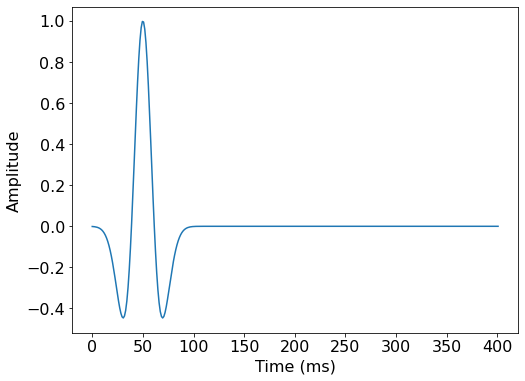

In [33]:
src.show()

For our PMLs, we will need a damping parameter. In this case, we will use a quadratic taper over the absorbing regions on the sides of the domain.

In [34]:
# Damping parameterisation
d_l = (1-0.1*x)**2  # Left side
d_r = (1-0.1*(grid.shape[0]-1-x))**2  # Right side
d_b = (1-0.1*(grid.shape[1]-1-y))**2  # Base edge

Now for our main domain equation:

In [35]:
from devito import Eq, grad, div

eq_u = Eq(u.forward, 2*u - u.backward + dt**2*velocity**2*u.laplace,
           subdomain=grid.subdomains['main'])

# Update our auxilliary field in the main body of the domain
eq_A = Eq(A.forward, A + grad(u),
          subdomain=grid.subdomains['main'])

And add the equations for our damped region:

In [36]:
# Left side
eq_u_l = Eq(u.forward, u - d_l*dt*u + dt*velocity**2*div(A.forward),
            subdomain=grid.subdomains['left'])

eq_A_l = Eq(A.forward, A - d_l*dt*A + grad(u),
            subdomain=grid.subdomains['left'])

# Right side
eq_u_r = Eq(u.forward, u - d_r*dt*u + dt*velocity**2*div(A.forward),
            subdomain=grid.subdomains['right'])

eq_A_r = Eq(A.forward, A - d_r*dt*A + grad(u),
            subdomain=grid.subdomains['right'])


# Base edge
eq_u_b = Eq(u.forward, u - d_b*dt*u + dt*velocity**2*div(A.forward),
            subdomain=grid.subdomains['base'])

eq_A_b = Eq(A.forward, A - d_b*dt*A + grad(u),
            subdomain=grid.subdomains['base'])


Add our free surface boundary conditions:

In [37]:
time = grid.stepping_dim

bc_u = [Eq(u[time+1, x, 3], 0.)]  # Set pressure field to zero at boundary

And our source terms:

In [38]:
src_term = src.inject(field=u.forward, expr=src*dt**2*velocity**2)

Construct our operator and run:

In [39]:
from devito import Operator

op = Operator([eq_A, eq_A_l, eq_A_r, eq_A_b,
               eq_u, eq_u_l, eq_u_r, eq_u_b]
              + src_term + bc_u)

op(time=time_range.num-1)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.007298999999999987, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=1.4000000000000003e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=2.600000000000001e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

It is important to remember that the ordering of equations when an `Operator` is created dictates the order of loops within the generated c code. Incorrect ordering can lead to updates occuring in the wrong order.

Now let's plot the wavefield.

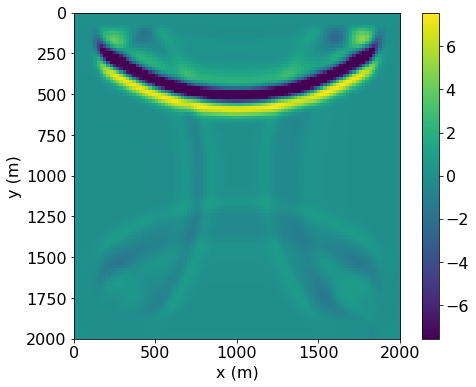

In [40]:
import matplotlib.pyplot as plt

u.data[:, :, :3] = 0 #  Mute out mirrored wavefield above free surface

scale = np.max(u.data[1])
fig = plt.figure()
plt.imshow(u.data[1].T,
           origin="upper",
           vmin=-scale, vmax=scale,
           extent=[0, grid.extent[0], grid.extent[1], 0])
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

As we can see, the wave is effectively damped at the edge of the domain by the 10 layers of PMLs, with diminished reflections back into the domain. The slight visible asymmetry arises due to the stagger of the auxilliary field, which is required for stability.